# A/B тест для Okko

Был запущен сплит-тест (а/б-тест), направленный на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах

1. Какие вы можете сделать выводы? Какая группа показала лучшие результаты?
2. Можем ли мы как-то оценить из этих данных равномерность и валидность распределения юзеров по разным группам?
3. Если не ограничиваться теми данными, которые приведены в рамках этого задания, что ещё вы бы посчитали для оценки результатов групп?

Описание данных:

В таблице users_ приведена информация о том, какой юзер в какой момент времени попал в а/б тест:
tag - лэйбл группы (control - контрольная, остальные - тестовые)
ts - время, когда впервые был выдан tag. То есть, все события до наступления времени ts происходили с юзером до попадания в а/б тест
user_uid - внутренний id юзера (для матчинга со второй таблицей)
registration_time - время регистрации пользователя в сервисе
conv_ts - время совершения первой покупки пользователем в сервисе

В таблице purchases_ приведена информация о транзакциях пользователей из таблицы users_ до и во время а/б теста:
user_uid - внутренний id юзера (для матчинга со второй таблицей)
time - время совершения транзакции
consumption_mode - вид потребления контента (dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка)
element_uid - уникальный id единицы контента или подписки
price - цена (преобразованная)

Значения в полях price и всех полях, указывающих на время - преобразованы. Это значит, что значение в таблице не настоящее, но является линейным преобразованием реального значения, где ко всем значениям одного поля применено одно и то же преобразование - между ними сохранено отношение порядка. Ко всем полям, обозначающим время, применено одно и то же преобразование.

#### Выполняет: Никита Лисоветин (telegram: https://t.me/nikitalisovetin) как тестовое задание в команду продуктовой аналитики в https://okko.ru

# Подключаем библиотеки

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp

# Загружаем данные a/b теста

In [3]:
df_users = pd.read_csv('users_.csv')
df_users.head()

,tag,ts,user_uid,registration_time,conv_ts
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691
1,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734
2,test1,30140.447675,32095e22f853e595a0f407ad081e7da8,27410.217536,27414.028899
3,control,30136.790772,9932d33f40ad07d7f3ddb7c6aee1bc60,27410.227367,27573.751226
4,test2,30150.339264,4a122db1ad0214e969df154d2dbb4622,27410.230786,29545.833019


In [4]:
df_purchases = pd.read_csv('purchases_.csv')
df_purchases.head()

,user_uid,time,consumption_mode,element_uid,price
0,d60a7038c7b7e99146ffea6f6535862b,30158.645112,dto,2ba66ac9785731da67b2b6155efaca5c,44.470588
1,0906074e1a1a9229b5e749860b646962,30158.645015,dto,e56d422275d90c96762f81db85d80f3d,38.588235
2,efb6eeca3135d573739e5c5d4dbce330,30158.644990,dto,544f7dd31bd61558c9c738adcff6aafa,50.352941
3,ccd658e372645c991ce49b444839712f,30158.644789,dto,8256d0fc7b25382aacfec0066e39cde3,44.470588
4,89ae5e43ff7b89f9d262d507dedc1760,30158.644200,dto,a579f32b5c116624cc661c9d3b96d5e5,44.470588


# Уберем покупки, совершенные до начала a/b тестирования

Вообще они тоже представляют интерес, но для начала решим нашу основную задачу в рамках тестового задания!

In [5]:
df_users_start = df_users.groupby(['user_uid'])['ts'].min().reset_index()

In [6]:
df_purchases_ts = df_purchases.merge(df_users_start, on='user_uid', how='left')
len(df_purchases_ts)

663849

In [7]:
df_purchases_test = df_purchases_ts[df_purchases_ts['time'] > df_purchases_ts['ts']]
df_purchases_before = df_purchases_ts[df_purchases_ts['time'] <= df_purchases_ts['ts']]
len(df_purchases_test), len(df_purchases_before)

(278479, 385370)

In [8]:
df_purchases = df_purchases_test[['user_uid', 'time', 'consumption_mode', 'element_uid', 'price']]

# Посмотрим на данные

In [9]:
len(df_users)

696982

In [10]:
len(np.unique(df_users['user_uid']))

694819

In [11]:
tags = np.unique(df_users['tag']).tolist()
tags

['control', 'test1', 'test2', 'test3', 'test4']

In [12]:
consumption_modes = np.unique(df_purchases['consumption_mode']).tolist()
consumption_modes

['dto', 'rent', 'subscription']

In [13]:
df_users_count = df_users.copy()
users_count = df_users_count.groupby(['user_uid'])['tag'].count().reset_index()
users_count.groupby(['tag'])['user_uid'].count().reset_index()

,tag,user_uid
0,1,692723
1,2,2032
2,3,61
3,4,3


Несколько пользователей за время теста успели поменять свой tag (т.е. >=2 записи в таблице users_). Для каждого из них можно аккуратно понять когда он был в какой группе и какие покупки он совершал, но этих пользователей настолько мало (<0.1%) и, скорее всего, они внесли настолько малый вклад в покупки (еще проверим), что во имя эффективности сразу забьем на них. Потому что для реализации их подсчета нужно будет потратить время и энергию, а на результат они все равно не повлияют

In [14]:
users_once = users_count[users_count['tag'] == 1]['user_uid'].tolist()
df_users_once = df_users[df_users['user_uid'].isin(users_once)]

len(df_users), len(df_users_once), 1 - len(df_users_once) / len(df_users)

(696982, 692723, 0.006110631264508948)

In [15]:
np.sum(df_purchases['price'])

10681185.588235294

In [16]:
df_purchases_once = df_purchases[df_purchases['user_uid'].isin(users_once)]

len(df_purchases), len(df_purchases_once)

(278479, 276778)

In [17]:
np.sum(df_purchases['price']), np.sum(df_purchases_once['price']), 1 - np.sum(df_purchases_once['price']) / np.sum(df_purchases['price'])

(10681185.588235294, 10616119.705882352, 0.006091634848533034)

Мы выкинем 0.61% пользователей, совершивших во время теста покупки на 0.61%. Нормально

In [18]:
df_users = df_users_once
df_purchases = df_purchases_once
df_purchases_before = df_purchases_before[df_purchases_before['user_uid'].isin(users_once)]

In [19]:
len(np.unique(df_purchases['user_uid'])), len(df_purchases['user_uid'])

(153958, 276778)

In [20]:
df_purchases.groupby('consumption_mode')['price'].agg(['sum', 'mean', 'median', 'count', 'min', 'max', 'var']).reset_index()

,consumption_mode,sum,mean,median,count,min,max,var
0,dto,3.974136e+06,38.784543,38.588235,102467,21.058824,140.000000,48.013330
1,rent,2.498330e+06,27.810825,26.823529,89833,22.705882,32.705882,4.334739
2,subscription,4.143654e+06,49.050097,44.470588,84478,21.058824,402.764706,202.292354


#### Таблица purchases_ полная или начало обрезано?

In [22]:
df_user_first = df_users[['user_uid', 'conv_ts']]
df_user_first = df_user_first.merge(df_purchases_before.groupby('user_uid')['time'].min(), how='left', on='user_uid')
df_user_first

,user_uid,conv_ts,time
0,001885550d78efd82c0f5cc02ad3369a,29485.529691,NaN
1,deb7d0e9bf9813d4f21b579d3703c6e1,27632.424734,30118.626008
2,32095e22f853e595a0f407ad081e7da8,27414.028899,NaN
3,9932d33f40ad07d7f3ddb7c6aee1bc60,27573.751226,NaN
4,4a122db1ad0214e969df154d2dbb4622,29545.833019,30110.800966
...,...,...,...
692718,e10d8044e619248ed68e54bc9f78efa9,27640.573832,NaN
692719,75c4da27fde4db78cf7e92e1847d1661,29293.210971,NaN
692720,d679d86c76c03f86e1459bde6b582664,29633.843281,NaN
692721,ca7d91f45bcc7eed9402a781e48cd6f5,27448.255112,NaN


In [26]:
df_user_first['time'].isna().sum(), len(df_user_first) - df_user_first['time'].isna().sum(), len(df_user_first[df_user_first['conv_ts'] != df_user_first['time']])

(462682, 230041, 692723)

In [28]:
df_user_first['conv_ts'].describe()

count    692448.000000
mean      29314.625361
std        1009.504229
min       25487.514148
25%       29025.920546
50%       29672.958953
75%       30023.370180
max       30246.655474
Name: conv_ts, dtype: float64

In [29]:
df_user_first['time'].describe()

count    230041.000000
mean      30121.266618
std          11.637868
min       30106.490995
25%       30111.145003
50%       30118.653347
75%       30128.779490
max       30158.469706
Name: time, dtype: float64

Да, таблица purchases_ обрезана, причем по всем пользователям

# Получим покупки для контрольной группы и остальных
Помним, что у нас теперь инвариант -- у каждого пользователя ровно 1 группа и все покупки он совершал в этой группе

In [20]:
df_purchases_tagged = df_purchases.merge(df_users[['user_uid', 'tag']], on='user_uid', how='left')

In [21]:
df_purchases_tagged.groupby(['consumption_mode', 'tag'])['price'].agg(['sum', 'mean', 'median', 'count', 'min', 'max', 'var']).reset_index()

,consumption_mode,tag,sum,mean,median,count,min,max,var
0,dto,control,735625.647059,39.530638,41.529412,18609,21.058824,140.000000,51.099100
1,dto,test1,805815.823529,38.614904,38.588235,20868,21.058824,140.000000,45.112915
2,dto,test2,805741.000000,38.954796,39.470588,20684,21.058824,126.823529,48.545894
3,dto,test3,806232.117647,38.597861,38.588235,20888,21.058824,126.823529,47.337649
4,dto,test4,820721.176471,38.319226,38.588235,21418,21.058824,140.000000,47.521601
5,rent,control,486184.235294,27.802610,26.823529,17487,22.705882,32.705882,4.302382
6,rent,test1,510014.823529,27.821014,26.823529,18332,22.705882,32.705882,4.361450
7,rent,test2,503853.764706,27.808034,26.823529,18119,22.705882,32.705882,4.348986
8,rent,test3,503162.705882,27.828257,26.823529,18081,22.705882,32.705882,4.359397
9,rent,test4,495114.352941,27.793553,26.823529,17814,22.705882,32.705882,4.299682


In [22]:
df_purchases_before_tagged = df_purchases_before.merge(df_users[['user_uid', 'tag']], on='user_uid', how='left')

In [23]:
df_purchases_before_tagged.groupby(['consumption_mode', 'tag'])['price'].agg(['count', 'sum', 'mean', 'median', 'count', 'min', 'max', 'var']).reset_index()

,consumption_mode,tag,count,sum,mean,median,count,min,max,var
0,dto,control,28036,9.011339e+05,32.142027,32.705882,28036,21.058824,109.235294,105.557190
1,dto,test1,28236,9.049726e+05,32.050313,32.705882,28236,21.058824,68.000000,104.359147
2,dto,test2,28445,9.142575e+05,32.141239,32.705882,28445,21.058824,73.882353,104.437007
3,dto,test3,28275,9.079518e+05,32.111470,32.705882,28275,21.058824,94.470588,105.160931
4,dto,test4,28410,9.108359e+05,32.060397,32.705882,28410,21.058824,109.235294,104.708799
5,rent,control,17532,4.880178e+05,27.835830,26.823529,17532,22.705882,32.705882,4.392168
6,rent,test1,17925,4.992576e+05,27.852588,26.823529,17925,23.294118,32.705882,4.399975
7,rent,test2,17578,4.890952e+05,27.824279,26.823529,17578,22.705882,32.705882,4.345180
8,rent,test3,17644,4.907549e+05,27.814268,26.823529,17644,22.705882,32.705882,4.260391
9,rent,test4,17247,4.803660e+05,27.852148,26.823529,17247,22.705882,32.705882,4.323181


In [24]:
df_purchases_before_tagged.groupby(['tag'])['price'].agg(['count', 'sum', 'mean', 'median', 'count', 'min', 'max', 'var']).reset_index()

,tag,count,sum,mean,median,count,min,max,var
0,control,76550,2.754364e+06,35.981236,32.705882,76550,21.058824,196.882353,160.619605
1,test1,77471,2.781800e+06,35.907625,32.705882,77471,21.058824,402.764706,160.757953
2,test2,76876,2.757414e+06,35.868327,32.705882,76876,21.058824,402.764706,159.206668
3,test3,76539,2.745861e+06,35.875315,32.705882,76539,21.058824,167.470588,160.398295
4,test4,76087,2.735439e+06,35.951459,32.705882,76087,21.058824,196.882353,160.704407


# Посмотрим на разные element_uid

## Распределение цен товаров нормально?

<AxesSubplot:xlabel='price'>

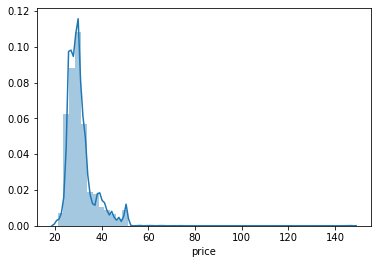

In [25]:
sns.distplot(df_purchases.groupby('element_uid')['price'].mean())

In [26]:
stats.normaltest(df_purchases.groupby('element_uid')['price'].mean())

NormaltestResult(statistic=4265.45330008279, pvalue=0.0)

pvalue < alpha = 0.05, значит, мы отвергаем гипотезу, что распределение цен по товарам нормальное

## Нет. А даже по отдельным категориям товаров?

NormaltestResult(statistic=695.6420545425195, pvalue=8.775000829090338e-152)


<AxesSubplot:xlabel='price'>

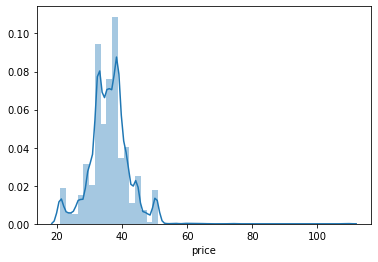

In [27]:
print(stats.normaltest(df_purchases[df_purchases['consumption_mode'] == 'dto'].groupby('element_uid')['price'].mean()))
sns.distplot(df_purchases[df_purchases['consumption_mode'] == 'dto'].groupby('element_uid')['price'].mean())

NormaltestResult(statistic=121.06044782647601, pvalue=5.152971804175874e-27)


<AxesSubplot:xlabel='price'>

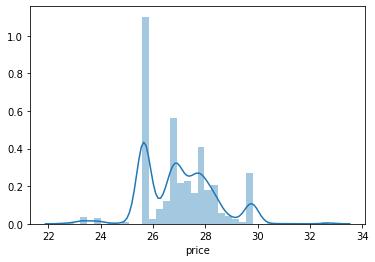

In [28]:
print(stats.normaltest(df_purchases[df_purchases['consumption_mode'] == 'rent'].groupby('element_uid')['price'].mean()))
sns.distplot(df_purchases[df_purchases['consumption_mode'] == 'rent'].groupby('element_uid')['price'].mean())

NormaltestResult(statistic=36.62415369565461, pvalue=1.1147207176852663e-08)


c:\users\nikit\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<AxesSubplot:xlabel='price'>

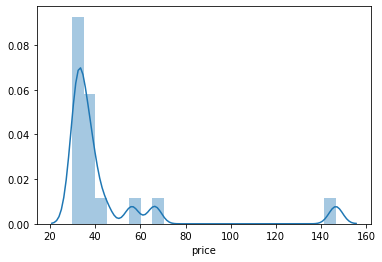

In [29]:
print(stats.normaltest(df_purchases[df_purchases['consumption_mode'] == 'subscription'].groupby('element_uid')['price'].mean()))
sns.distplot(df_purchases[df_purchases['consumption_mode'] == 'subscription'].groupby('element_uid')['price'].mean())

## Да.

## Сколько каждого типа?

In [30]:
df_purchases.element_uid.nunique()

5593

In [31]:
df_purchases.groupby('consumption_mode')['element_uid'].nunique()

consumption_mode
dto             3940
rent            4198
subscription      17
Name: element_uid, dtype: int64

In [32]:
dto_uids = df_purchases[df_purchases['consumption_mode'] == 'dto'].element_uid.unique()
rent_uids = df_purchases[df_purchases['consumption_mode'] == 'rent'].element_uid.unique()

dto_rent = list(set(dto_uids) & set(rent_uids))

len(dto_uids), len(rent_uids), len(dto_rent), len(dto_rent) / max(len(dto_uids), len(rent_uids))

(3940, 4198, 2562, 0.6102906145783706)

In [33]:
len(df_purchases[df_purchases['consumption_mode'] == 'dto'])

102467

## Сравним топ популярных до и после начала теста

In [34]:
df_purchases[df_purchases['consumption_mode'] != 'subscription'].groupby(['consumption_mode','element_uid'])['price'].count().reset_index().sort_values(by=['price'], ascending=False).head(25)

,consumption_mode,element_uid,price
2555,dto,a579f32b5c116624cc661c9d3b96d5e5,15386
2012,dto,8256d0fc7b25382aacfec0066e39cde3,5856
987,dto,433b78d303f6d499b72cb55a746f7c9c,5527
3660,dto,ef81ae50ce292ed4ee547c775f29a35e,4532
629,dto,2ba66ac9785731da67b2b6155efaca5c,3469
7079,rent,c182cf88cc73c97dc744c9a66cb247ae,3395
5928,rent,7af6df3758b7e4729261a7f56db60aae,2706
2228,dto,91149a8df75aa9c9f8bab2a2d777c856,2461
5376,rent,5aa724c0393087cde3a18c625b310645,2080
5360,rent,59c2968c95c14c3aa5ab68990431551a,1976


In [35]:
dto_count = df_purchases[df_purchases['consumption_mode'] == 'dto'].groupby('element_uid')['price'].agg(['count', 'sum', 'min', 'mean', 'max', 'var']).sort_values(by=['count'], ascending=False)
dto_count.head(20)

,count,sum,min,mean,max,var
element_uid,,,,,,
a579f32b5c116624cc661c9d3b96d5e5,15386,635083.352941,21.058824,41.276703,44.470588,33.041457
8256d0fc7b25382aacfec0066e39cde3,5856,234716.470588,21.058824,40.081365,44.470588,29.098501
433b78d303f6d499b72cb55a746f7c9c,5527,207940.000000,21.058824,37.622580,44.470588,37.562693
ef81ae50ce292ed4ee547c775f29a35e,4532,179972.941176,21.058824,39.711593,44.470588,28.311204
2ba66ac9785731da67b2b6155efaca5c,3469,131609.058824,21.058824,37.938616,44.470588,37.269731
91149a8df75aa9c9f8bab2a2d777c856,2461,95585.470588,21.058824,38.840094,59.823529,48.722297
194a4dd907083e2377e7b0f8b1d970e9,1847,71292.941176,21.058824,38.599318,44.470588,31.020237
c182cf88cc73c97dc744c9a66cb247ae,1538,55912.352941,21.058824,36.353936,44.470588,89.732408
d1e7961cec31b92522e159992a7afe71,1472,55878.000000,21.058824,37.960598,41.529412,22.005527


In [36]:
dto_before_count = df_purchases_before[df_purchases_before['consumption_mode'] == 'dto'].groupby('element_uid')['price'].agg(['count', 'sum', 'min', 'mean', 'max', 'var']).sort_values(by=['count'], ascending=False)
dto_before_count.head(20)

,count,sum,min,mean,max,var
element_uid,,,,,,
7af6df3758b7e4729261a7f56db60aae,9415,282583.764706,21.058824,30.014208,44.470588,107.402671
c182cf88cc73c97dc744c9a66cb247ae,8276,224654.117647,21.058824,27.145253,44.470588,92.929445
6bd1c6bdef06ecd5b14dde52d1987e7e,3818,110052.235294,21.058824,28.824577,44.470588,109.004542
91149a8df75aa9c9f8bab2a2d777c856,3510,122898.294118,21.058824,35.013759,59.823529,104.426396
1453b8da7c9ca23c4b8c9158b2ecbcda,3382,88384.588235,21.058824,26.133823,44.470588,84.026315
5aa724c0393087cde3a18c625b310645,2752,70920.588235,21.058824,25.770563,44.470588,79.070467
a579f32b5c116624cc661c9d3b96d5e5,2628,62301.882353,21.058824,23.706957,44.470588,47.169470
492919bf10974511bcb6f026c0151393,2174,91349.647059,38.588235,42.019157,44.470588,8.414539
a83496f29d764162ffa9dcd6cc012bd3,1902,79494.823529,32.705882,41.795386,44.470588,8.693502


In [37]:
np.sum(dto_count['count'].head(20)) / np.sum(dto_count['count']), np.sum(dto_count['sum'].head(20)) / np.sum(dto_count['sum'])

(0.49548635170347527, 0.5037278989314355)

В контрольной группе тоже изменился топ-20 популярных?

In [38]:
dto_count_control = df_purchases_tagged[(df_purchases_tagged['tag'] == 'control') & (df_purchases_tagged['consumption_mode'] == 'dto')].groupby('element_uid')['price'].agg(['count', 'sum', 'min', 'mean', 'max', 'var']).sort_values(by=['count'], ascending=False)
dto_count_control.head(20)

,count,sum,min,mean,max,var
element_uid,,,,,,
a579f32b5c116624cc661c9d3b96d5e5,2813,118186.588235,21.058824,42.014429,44.470588,38.052276
8256d0fc7b25382aacfec0066e39cde3,1127,46282.823529,21.058824,41.067279,44.470588,27.691902
433b78d303f6d499b72cb55a746f7c9c,932,36989.647059,21.058824,39.688463,44.470588,32.655062
ef81ae50ce292ed4ee547c775f29a35e,874,35186.117647,21.058824,40.258716,44.470588,32.400534
2ba66ac9785731da67b2b6155efaca5c,605,24449.411765,21.058824,40.412251,44.470588,29.278884
91149a8df75aa9c9f8bab2a2d777c856,457,17837.764706,21.058824,39.032308,59.823529,56.097957
194a4dd907083e2377e7b0f8b1d970e9,328,13142.823529,21.058824,40.069584,44.470588,25.370930
c182cf88cc73c97dc744c9a66cb247ae,272,9779.294118,21.058824,35.953287,44.470588,114.696823
d1e7961cec31b92522e159992a7afe71,268,10210.588235,21.058824,38.099210,41.529412,20.745975


In [39]:
dto_before_count_control = df_purchases_before_tagged[(df_purchases_before_tagged['tag'] == 'control') & (df_purchases_before_tagged['consumption_mode'] == 'dto')].groupby('element_uid')['price'].agg(['count', 'sum', 'min', 'mean', 'max', 'var']).sort_values(by=['count'], ascending=False)
dto_before_count_control.head(20)

,count,sum,min,mean,max,var
element_uid,,,,,,
7af6df3758b7e4729261a7f56db60aae,1893,57417.411765,21.058824,30.331438,44.470588,109.827727
c182cf88cc73c97dc744c9a66cb247ae,1606,43590.235294,21.058824,27.142114,44.470588,93.087407
6bd1c6bdef06ecd5b14dde52d1987e7e,777,22473.529412,21.058824,28.923461,44.470588,109.419352
91149a8df75aa9c9f8bab2a2d777c856,708,24809.117647,21.058824,35.041127,59.823529,104.547745
1453b8da7c9ca23c4b8c9158b2ecbcda,672,17869.176471,21.058824,26.591036,44.470588,90.275169
5aa724c0393087cde3a18c625b310645,577,14936.823529,21.058824,25.887043,44.470588,80.914218
a579f32b5c116624cc661c9d3b96d5e5,501,12103.647059,21.058824,24.158976,44.470588,55.798704
492919bf10974511bcb6f026c0151393,445,18760.000000,38.588235,42.157303,44.470588,8.274866
584e2b6ed08ad5a9de256a553de203f3,382,13711.294118,32.705882,35.893440,38.588235,8.612361


В контрольной группе топ-20 до и после начала теста тоже сильно отличаются. Более того, они очень похожи на топы по всем группам соответственно до и после начала теста

In [40]:
subscriptions_count = df_purchases[df_purchases['consumption_mode'] == 'subscription'].groupby('element_uid')['price'].agg(['count', 'sum', 'min', 'mean', 'max', 'var']).sort_values(by=['count'], ascending=False)
subscriptions_count

,count,sum,min,mean,max,var
element_uid,,,,,,
dd7f3f7b10fb9b502cbc5d1a9abc067b,28204,1.112762e+06,21.058824,39.454039,196.882353,55.622770
8a6d58e6725f9122361450a13c9eb701,25107,1.664574e+06,44.470588,66.299216,402.764706,40.993726
6044f6995c3da1720dd814bafe3b2349,13448,5.190464e+05,38.588235,38.596546,41.529412,0.024377
fffeaa1a86125af9efbb98292a9bdfb5,10399,5.847908e+05,56.235294,56.235294,56.235294,0.000000
fcadbb06e4d06563830abed6eff0a815,3746,1.420869e+05,21.058824,37.930310,53.294118,186.854340
d84a832e160ad7c43f99cefc8c132115,1460,4.735529e+04,21.411765,32.435133,32.705882,2.986616
2030f498a14d3f787012367afc1f6ebc,1156,3.780800e+04,32.705882,32.705882,32.705882,0.000000
a3deed2b331bf35c60c0589ee5986870,579,1.893671e+04,32.705882,32.705882,32.705882,0.000000
13690e732ee775aa0d3bac6c0479c8c1,113,3.695765e+03,32.705882,32.705882,32.705882,0.000000


In [41]:
subscriptions_before_count = df_purchases_before[df_purchases_before['consumption_mode'] == 'subscription'].groupby('element_uid')['price'].agg(['count', 'sum', 'min', 'mean', 'max', 'var']).sort_values(by=['count'], ascending=False)
subscriptions_before_count

,count,sum,min,mean,max,var
element_uid,,,,,,
dd7f3f7b10fb9b502cbc5d1a9abc067b,74869,2.735917e+06,21.058824,36.542717,196.882353,53.635801
8a6d58e6725f9122361450a13c9eb701,23833,1.583536e+06,44.470588,66.442999,402.764706,44.183901
6044f6995c3da1720dd814bafe3b2349,22414,8.651167e+05,38.588235,38.597158,41.529412,0.026166
fffeaa1a86125af9efbb98292a9bdfb5,20333,1.143432e+06,56.235294,56.235294,56.235294,0.000000
fcadbb06e4d06563830abed6eff0a815,6832,2.564020e+05,21.058824,37.529567,53.294118,188.414491
d84a832e160ad7c43f99cefc8c132115,2306,7.529553e+04,21.411765,32.652008,32.705882,0.605829
2030f498a14d3f787012367afc1f6ebc,1992,6.515012e+04,32.705882,32.705882,32.705882,0.000000
a3deed2b331bf35c60c0589ee5986870,999,3.267318e+04,32.705882,32.705882,32.705882,0.000000
7ff3bf7b24885647ffc80d3ec647ac86,166,5.920353e+03,35.647059,35.664777,38.588235,0.052112


In [42]:
popular_subscriptions = subscriptions_before_count[subscriptions_before_count['count'] > 10000]

np.sum(popular_subscriptions['sum']), np.sum(popular_subscriptions['sum']) / np.sum(subscriptions_before_count['sum']), \
np.sum(popular_subscriptions['count']), np.sum(popular_subscriptions['count']) / np.sum(subscriptions_before_count['count']) 

(6328001.58823164, 0.9322016131062725, 141449, 0.9173384350984144)

Подписок -- по пальцам рук и ног пересчитать.

Купить навсегда или арендовать -- по ~4000, пересекаются на 60%. Топ-20 до и после начала теста сильно отличаются. После начала теста топ-20 товаров dto составляют ~50% от количества покупок и от суммы покупок.


Рейтинг топа подписок не изменился с началом теста. Подписок, оформленных хотя бы 10000 раз до теста, всего 4 и идут они с большим отрывом от остальных. Они составляют 93% по сумме и 91% по количеству от всех оформленных подписок. Поэтому они представляют особенный интерес. Будем называть их "популярными подписками".

## Различается ли стоимость одного и того же element_uid от покупки. Зависит ли цена только от группы?

In [43]:
df_purchases_elements = df_purchases_tagged.groupby(['element_uid', 'tag', 'consumption_mode'])['price'].agg(['min', 'mean', 'max', 'var', 'count']).reset_index()
df_purchases_elements.head(20)

,element_uid,tag,consumption_mode,min,mean,max,var,count
0,0046797fc7376ddb4cd05e27a40d6ea5,control,dto,38.588235,38.588235,38.588235,NaN,1
1,0046797fc7376ddb4cd05e27a40d6ea5,test2,rent,25.647059,25.647059,25.647059,NaN,1
2,0046797fc7376ddb4cd05e27a40d6ea5,test4,dto,33.294118,36.823529,38.588235,9.342561,3
3,00474060bfcb0715809534076f5d6231,control,dto,21.058824,43.382353,47.411765,83.127039,8
4,00474060bfcb0715809534076f5d6231,test1,dto,21.058824,39.239216,47.411765,97.744670,15
5,00474060bfcb0715809534076f5d6231,test2,dto,21.058824,40.856209,47.411765,112.651480,9
6,00474060bfcb0715809534076f5d6231,test3,dto,42.117647,44.823529,47.411765,2.399077,10
7,00474060bfcb0715809534076f5d6231,test4,dto,21.058824,42.987395,47.411765,49.555059,14
8,00513cfc64da60d680b7c4508b58b19e,test2,rent,29.764706,29.764706,29.764706,NaN,1
9,0055c41ccfad99e7c3b1e9434c9ebd6b,control,dto,23.882353,23.882353,23.882353,NaN,1


In [44]:
len(df_purchases_elements), len(df_purchases_elements[df_purchases_elements['min'] != df_purchases_elements['max']])

(22866, 9625)

In [45]:
df_purchases_elements[(df_purchases_elements['consumption_mode'] == 'subscription') & (df_purchases_elements['min'] != df_purchases_elements['max'])]

,element_uid,tag,consumption_mode,min,mean,max,var,count
8234,6044f6995c3da1720dd814bafe3b2349,control,subscription,38.588235,38.599305,41.529412,0.032447,2657
8235,6044f6995c3da1720dd814bafe3b2349,test1,subscription,38.588235,38.594648,41.529412,0.018826,2752
8236,6044f6995c3da1720dd814bafe3b2349,test2,subscription,38.588235,38.600130,41.529412,0.034855,2720
8237,6044f6995c3da1720dd814bafe3b2349,test3,subscription,38.588235,38.594791,41.529412,0.019245,2692
8238,6044f6995c3da1720dd814bafe3b2349,test4,subscription,38.588235,38.593833,41.529412,0.016440,2627
12180,8a6d58e6725f9122361450a13c9eb701,control,subscription,44.470588,66.274732,68.000000,36.279660,4937
12181,8a6d58e6725f9122361450a13c9eb701,test1,subscription,44.470588,66.531351,402.764706,54.720565,5035
12182,8a6d58e6725f9122361450a13c9eb701,test2,subscription,44.470588,66.377420,138.058824,35.172909,4967
12183,8a6d58e6725f9122361450a13c9eb701,test3,subscription,44.470588,66.023348,68.000000,41.383538,5190
12184,8a6d58e6725f9122361450a13c9eb701,test4,subscription,44.470588,66.298289,138.058824,37.078820,4978


In [46]:
df_purchases_elements[(df_purchases_elements['consumption_mode'] == 'dto') & (df_purchases_elements['min'] != df_purchases_elements['max'])]

,element_uid,tag,consumption_mode,min,mean,max,var,count
2,0046797fc7376ddb4cd05e27a40d6ea5,test4,dto,33.294118,36.823529,38.588235,9.342561,3
3,00474060bfcb0715809534076f5d6231,control,dto,21.058824,43.382353,47.411765,83.127039,8
4,00474060bfcb0715809534076f5d6231,test1,dto,21.058824,39.239216,47.411765,97.744670,15
5,00474060bfcb0715809534076f5d6231,test2,dto,21.058824,40.856209,47.411765,112.651480,9
6,00474060bfcb0715809534076f5d6231,test3,dto,42.117647,44.823529,47.411765,2.399077,10
...,...,...,...,...,...,...,...,...
22835,ffc5f0851d89b950f7fb56e3a0a0776f,control,dto,21.058824,35.105882,44.470588,164.433218,5
22837,ffc5f0851d89b950f7fb56e3a0a0776f,test1,dto,21.058824,30.423529,44.470588,164.433218,5
22840,ffc5f0851d89b950f7fb56e3a0a0776f,test3,dto,38.588235,41.529412,44.470588,17.301038,2
22846,fff4144b09cd1263025849f7f169e06a,test1,dto,29.176471,32.264706,35.352941,19.074394,2


In [47]:
df_purchases_elements[(df_purchases_elements['consumption_mode'] == 'rent') & (df_purchases_elements['min'] != df_purchases_elements['max'])]

,element_uid,tag,consumption_mode,min,mean,max,var,count
10,005b44d39e7c954c75bd44a370db1476,control,rent,26.823529,28.294118,29.764706,4.325260,2
11,005b44d39e7c954c75bd44a370db1476,test1,rent,26.823529,27.803922,29.764706,2.883506,3
16,005b44d39e7c954c75bd44a370db1476,test4,rent,26.823529,28.294118,29.764706,4.325260,2
38,00b46907704f2054e2cc5cec0f47ca77,test1,rent,25.647059,28.117647,29.764706,5.086505,5
45,00ba72b0b0a9fbca42fe3f98f1064baf,control,rent,25.647059,28.000000,29.764706,4.844291,7
...,...,...,...,...,...,...,...,...
22845,fff4144b09cd1263025849f7f169e06a,control,rent,25.647059,27.705882,29.764706,5.651672,4
22848,fff4144b09cd1263025849f7f169e06a,test2,rent,25.647059,28.392157,29.764706,5.651672,3
22853,fffd778c45c42285c8deae2b1f79aa70,control,rent,26.823529,27.803922,29.764706,2.883506,3
22858,fffd778c45c42285c8deae2b1f79aa70,test3,rent,26.823529,27.558824,29.764706,2.162630,4


Да, различается. Внутри групп тоже различается.

# Оценка равномерности и валидности распределения юзеров по разным группам

## По timestamp'ам

Хотелось бы понять, что:
1. a/b тест проведен корректно: тест запустили в один момент и идет до последнего момента, для которого у нас есть данные. Это гарантировало бы, что увеличение метрик в какой-то группе не связано с тем, что "был выходной/праздник и все усиленно покупали", "вышел новый блокбастер", в то время как другие группы тестировались во время "будних", "обычное скучное время".
1. Можно ли сравнивать суммарные доходы по группам исходя из того, что тест был запущен в один момент и шел до конца? Если какая-то тестовая группа была запущена сильно позже других, то, очевидно, в ней суммарный доход будет меньше, чем в других, при этом сделать вывод о том, что она менее прибыльная - нельзя.


Timestamp'ы представлены в нестандартном формате. Единственное, что мы можем с ними делать -- это сравнивать. Давайте посравниваем

In [48]:
alpha = 0.05

def compareGroups(dataframe, yaxis):
    control = dataframe[dataframe['tag'] == 'control'][yaxis]
    test1 = dataframe[dataframe['tag'] == 'test1'][yaxis]
    test2 = dataframe[dataframe['tag'] == 'test2'][yaxis]
    test3 = dataframe[dataframe['tag'] == 'test3'][yaxis]
    test4 = dataframe[dataframe['tag'] == 'test4'][yaxis]
    
    print("Все вместе")
    kruskal_result = stats.kruskal(control, test1, test2, test3, test4)
    print(kruskal_result)
    print()
    print("Между собой")
    if (kruskal_result.pvalue < alpha):
        print("pvalue < alpha = " + str(alpha) + ", значит, мы отклоняем нулевую гипотезу о том, что медианы выборок одинаковы")
        print("Для того, чтобы выяснить медианы каких именно выборок отличаются, запустим специальный post hoc Краскалла с отклоненной нулевой гипотезой тест Коновера-Имана с поправками Benjamini/Hochberg (non-negative).")
        print("Если значение p-value < alpha = " + str(alpha) + ", то медианы пары выборок отличаются значимо, иначе незначимо")
        pd.options.display.float_format = "{:,.3f}".format
        tmp = sp.posthoc_conover([control, test1, test2, test3, test4], p_adjust = 'fdr_bh')
        tmp.columns = ['control', 'test1', 'test2', 'test3', 'test4']
        tmp = tmp.rename(index={1: 'control', 2: 'test1', 3: 'test2', 4: 'test3', 5: 'test4'})
        print(tmp)
    else:
        print("Kruskal pvalue > alpha = " + str(alpha) + ", значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы")
    
    print("Графики распределения групп по параметру " + yaxis + ":")
    sns.distplot(control, kde_kws={"label": "control"})
    sns.distplot(test1, kde_kws={"label": "test1"})
    sns.distplot(test2, kde_kws={"label": "test2"})
    sns.distplot(test3, kde_kws={"label": "test3"})
    sns.distplot(test4, kde_kws={"label": "test4"})

In [49]:
df_purchases_tagged.groupby('tag')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
control,52688.0,30146.753217,7.147621,30132.312150,30140.473857,30147.144129,30152.896198,30158.645112
test1,56357.0,30146.758772,7.149033,30132.315314,30140.487500,30147.173199,30152.890978,30158.644990
test2,55707.0,30146.745086,7.156146,30132.315569,30140.480897,30147.102418,30152.883139,30158.643735
test3,56027.0,30146.794180,7.140943,30132.312102,30140.506293,30147.186420,30152.904204,30158.643709
test4,55999.0,30146.741158,7.156110,30132.313587,30140.478352,30147.121990,30152.890217,30158.644789


Все вместе
KruskalResult(statistic=2.3608569400387807, pvalue=0.6697122967529086)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру time:


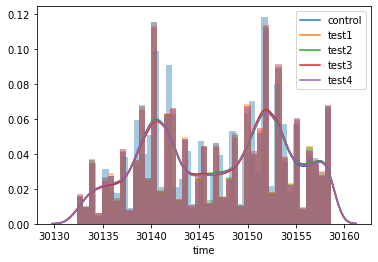

In [50]:
compareGroups(df_purchases_tagged, 'time')

In [51]:
pd.set_option('display.max_columns', None)
df_users.groupby('tag').describe()

ts                                                      \
            count          mean       std           min           25%   
tag                                                                     
control  138155.0  30141.117754  7.215688  30132.310521  30135.107260   
test1    139227.0  30141.139174  7.221643  30132.310512  30135.126401   
test2    138532.0  30141.142719  7.220269  30132.310551  30135.134375   
test3    138404.0  30141.151298  7.211822  30132.310547  30135.157349   
test4    138405.0  30141.153202  7.221178  30132.310515  30135.132599   

                                                  registration_time  \
                  50%           75%           max             count   
tag                                                                   
control  30139.790608  30145.723233  30158.507833          138056.0   
test1    30139.778245  30146.140696  30158.508659          139133.0   
test2    30139.796392  30146.080961  30158.508711          138436.0   
test3    30139.817802  30146.103678  30158.508648          138306.0   
test4    30139.813461  30146.146062  30158.508048          138320.0   

                                                                              \
                 mean          std           min           25%           50%   
tag                                                                            
control  28747.299372  1256.486049  25037.711284  27953.868092  29152.564184   
test1    28745.471620  1259.962692  25033.741165  27932.134196  29160.978518   
test2    28748.200797  1258.768676  25038.623263  27940.374710  29160.652969   
test3    28750.200080  1255.409054  25035.707289  27960.502994  29159.539130   
test4    28744.052070  1259.168973  25033.711649  27938.734069  29151.242142   

                                      conv_ts                             \
                  75%           max     count          mean          std   
tag                                                                        
control  29786.896671  30246.248574  138094.0  29315.411823  1008.145695   
test1    29788.594083  30246.250068  139171.0  29313.919434  1010.849686   
test2    29789.588663  30246.230107  138480.0  29314.364200  1009.642970   
test3    29787.653644  30246.250943  138345.0  29315.466690  1007.882475   
test4    29786.778577  30246.251018  138358.0  29313.970615  1010.998755   

                                                                              
                  min           25%           50%          75%           max  
tag                                                                           
control  25487.514148  29024.290727  29672.958953  30023.37018  30246.655474  
test1    25487.514148  29027.550366  29674.588772  30023.37018  30246.655474  
test2    25487.514148  29024.290727  29674.588772  30023.37018  30246.655474  
test3    25487.514148  29030.810005  29671.329133  30023.37018  30246.655474  
test4    25487.514148  29024.290727  29674.588772  30023.37018  30246.655474

Все вместе
KruskalResult(statistic=2.7612960760016234, pvalue=0.5985319915646772)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру ts:


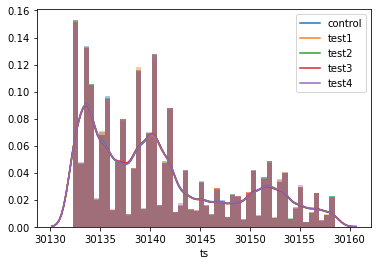

In [52]:
compareGroups(df_users, 'ts')

Все вместе
KruskalResult(statistic=nan, pvalue=nan)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру registration_time:


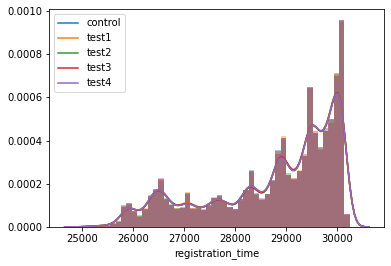

In [53]:
compareGroups(df_users, 'registration_time')

Все вместе
KruskalResult(statistic=nan, pvalue=nan)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру conv_ts:


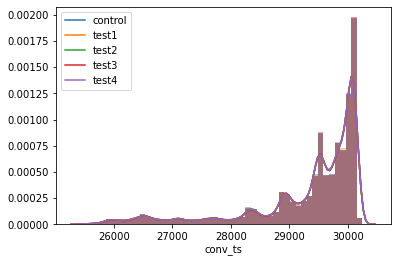

In [54]:
compareGroups(df_users, 'conv_ts')

## По тратам до теста

In [55]:
pd.set_option('display.max_columns', None)
df_purchases_before_tagged.groupby('tag').describe()

time                                                       \
           count          mean        std           min           25%   
tag                                                                     
control  76550.0  30122.488850  10.704133  30106.490995  30114.233424   
test1    77471.0  30122.488912  10.758018  30106.492535  30114.206271   
test2    76876.0  30122.531609  10.778022  30106.491145  30114.244776   
test3    76539.0  30122.518485  10.728813  30106.491574  30114.267064   
test4    76087.0  30122.609882  10.815841  30106.491286  30114.280080   

                                                     price             \
                  50%           75%           max    count       mean   
tag                                                                     
control  30120.953674  30129.128570  30158.413775  76550.0  35.981236   
test1    30120.898782  30129.114679  30158.358105  77471.0  35.907625   
test2    30120.917843  30129.131114  30158.375243  76876.0  35.868327   
test3    30120.910018  30129.136308  30158.442999  76539.0  35.875315   
test4    30120.937812  30129.159599  30158.469706  76087.0  35.951459   

                                                                            \
               std        min        25%        50%        75%         max   
tag                                                                          
control  12.673579  21.058824  26.823529  32.705882  44.470588  196.882353   
test1    12.679036  21.058824  26.823529  32.705882  44.470588  402.764706   
test2    12.617712  21.058824  26.823529  32.705882  44.470588  402.764706   
test3    12.664845  21.058824  26.823529  32.705882  44.470588  167.470588   
test4    12.676924  21.058824  26.823529  32.705882  44.470588  196.882353   

              ts                                                      \
           count          mean       std           min           25%   
tag                                                                    
control  76550.0  30139.257612  6.718585  30132.310521  30133.847565   
test1    77471.0  30139.270409  6.721853  30132.310512  30133.850036   
test2    76876.0  30139.260182  6.714130  30132.310553  30133.856535   
test3    76539.0  30139.309190  6.736837  30132.310569  30133.870199   
test4    76087.0  30139.299105  6.727608  30132.310561  30133.856742   

                                                   
                  50%           75%           max  
tag                                                
control  30137.255364  30141.936158  30158.506747  
test1    30137.265753  30141.936323  30158.508286  
test2    30137.243605  30141.929493  30158.506737  
test3    30137.295280  30141.953724  30158.508648  
test4    30137.283887  30141.976484  30158.507249

Все вместе
KruskalResult(statistic=4.626326833626191, pvalue=0.3278300422446007)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру price:


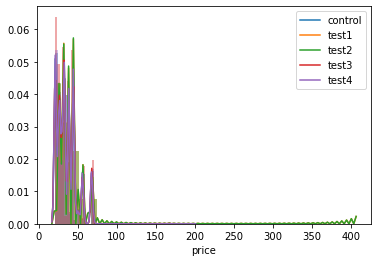

In [56]:
compareGroups(df_purchases_before_tagged, 'price')

In [57]:
pd.set_option('display.max_columns', None)
df_purchases_before_tagged_stats = df_purchases_before_tagged.groupby(['consumption_mode', 'tag', 'user_uid'])['price'].agg(['count', 'sum', 'mean']).reset_index()
df_purchases_before_tagged_stats.groupby('tag').describe()

count                                                    sum  \
           count      mean       std  min  25%  50%  75%   max    count   
tag                                                                       
control  57880.0  1.322564  0.860125  1.0  1.0  1.0  1.0  27.0  57880.0   
test1    58718.0  1.319374  0.853048  1.0  1.0  1.0  1.0  23.0  58718.0   
test2    58236.0  1.320077  0.854081  1.0  1.0  1.0  1.0  24.0  58236.0   
test3    57886.0  1.322237  0.866390  1.0  1.0  1.0  1.0  29.0  57886.0   
test4    57669.0  1.319374  0.852207  1.0  1.0  1.0  1.0  44.0  57669.0   

                                                                           \
              mean        std        min        25%        50%        75%   
tag                                                                         
control  47.587484  34.783804  21.058824  26.823529  38.588235  56.235294   
test1    47.375585  34.351900  21.058824  26.823529  38.588235  56.235294   
test2    47.348951  34.595717  21.058824  26.823529  38.588235  56.235294   
test3    47.435663  34.794367  21.058824  26.823529  38.588235  56.235294   
test4    47.433433  34.819337  21.058824  26.823529  38.588235  56.235294   

                         mean                                              \
                 max    count       mean        std        min        25%   
tag                                                                         
control  1008.470588  57880.0  35.829563  13.228008  21.058824  25.647059   
test1     940.117647  58718.0  35.765455  13.261433  21.058824  25.647059   
test2     837.882353  58236.0  35.690387  13.226459  21.058824  25.647059   
test3     869.058824  57886.0  35.740029  13.211867  21.058824  25.647059   
test4    1859.882353  57669.0  35.790194  13.248709  21.058824  25.647059   

                                           
               50%        75%         max  
tag                                        
control  32.705882  44.470588  196.882353  
test1    32.705882  44.470588  402.764706  
test2    32.705882  44.470588  402.764706  
test3    32.705882  44.470588  167.470588  
test4    32.705882  44.470588  196.882353

Все вместе
KruskalResult(statistic=1.676206367878451, pvalue=0.7950350936606421)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру count:


c:\users\nikit\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\nikit\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\nikit\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\nikit\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\nikit\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping

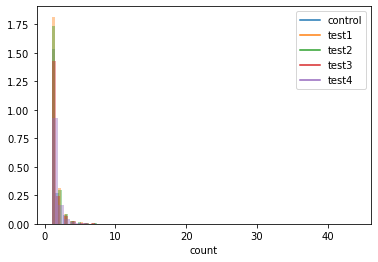

In [58]:
compareGroups(df_purchases_before_tagged_stats, 'count')

Все вместе
KruskalResult(statistic=3.9358112457322143, pvalue=0.4147625478784259)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру sum:


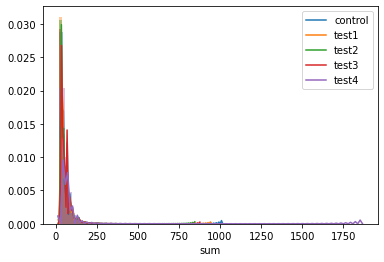

In [59]:
compareGroups(df_purchases_before_tagged_stats, 'sum')

Все вместе
KruskalResult(statistic=4.25757148006631, pvalue=0.3722681864151078)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы
Графики распределения групп по параметру mean:


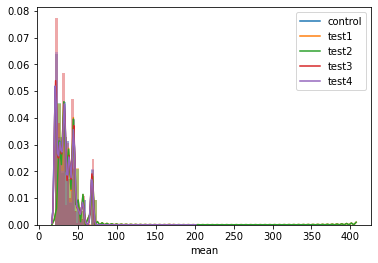

In [60]:
compareGroups(df_purchases_before_tagged_stats, 'mean')

## Вывод: распределение по группам равномерное

По всем основным показателям действий пользователей:
* Время попадания в тест
* Количество покупок до теста
* Сумма покупок до теста
* Средняя цена покупки до теста
* Время регистрации
* Время первой покупки

пользователи распределены равномерно по группам (но дополнительно следует убедиться в корректности "обрезки начала" таблицы purchases_, потому что она у нас неполная).

Это говорит о том, что с высокой вероятностью они действительно равномерно распределены по группам и результаты анализа будут валидны. Тест был поставлен удачно, такую же стратегию распределения по группам можно использовать и дальше.

Почему "с высокой вероятностью", а не точно? Пользователи выделяются и по другим показателям, такие как: пол, возраст, город, средний доход в городе, зарплата, интересы, последняя подписка на 12 месяцев и другие. Существует вероятность того, что "любители детских фильмов" никак не выделялись до теста, но попали в одну группу. А в тесте запустят в разном виде новое предложение с детскими фильмами. Конечно, эти любители сразу начнут покупать их. Мы увидим, что доход увеличился и совершим ошибку: отдадим предпочтение тому варианту, где больше любителей, а не тот, который более прибыльный. Однако, так как изученные показатели действительно хорошие и по ним мы узнали, что распределение по группам равномерное, то вероятность такого очень мала. Но не 0.

В зависимости от поставленной гипотезы и проверяемой фичи дополнительно нужно проверять равномерность распределения по другим параметрам. Если мы, опять же, запускаем детские фильмы, то нужно проверять равномерность распределения по любителям детских фильмов (то есть хотя бы по возрасту или "в браке и >=30 лет (значит, есть ребенок)"). Если запускаем футбол, то нужно проверять, что везде мужчин поровну. Если балет - то женщин. И так далее.

# Какая группа принесла больше денег?

У нас есть три разных типа товаров: dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка.

Проанализируем доходы по группам общие и по типам товаров. Таким образом мы сможем найти не только наиболее удачную группу, но и наиболее удачные решения по типам товаров, показать наиболее полную картину и дать лучшие рекомендации.

Метрики, которые мы будем считать:
* users: количество пользователей в группе
* buyers: количество покупателей
* purchases: количество покупок
* purchases / buyer: среднее количество покупок на покупателя
* CR user -> purchase: конверсия из пользователей в группе в покупку
* GMV: общий доход
* GMV / purchase: средняя покупка
* GMV / buyer: средняя сумма потраченная пользователем за период теста

## В сумме

In [61]:
df_users.groupby('tag')['user_uid'].describe()

,count,unique,top,freq
tag,,,,
control,138155,138155,84e36c63f0def6b030bd5a6112d1d215,1
test1,139227,139227,40e2f95d73ab3e9e4ea8a8f92667f900,1
test2,138532,138532,b98c39056b35bdbfe3f0f058db937379,1
test3,138404,138404,67d47ab668da2b8b5de3734ae510fc46,1
test4,138405,138405,5d34e102e5dd4f33eec5c515ff3330e2,1


In [62]:
df_purchases_tagged.groupby('tag')['user_uid'].describe()

,count,unique,top,freq
tag,,,,
control,52688,29872,f13681216d3f6f31ad97c034db307b03,27
test1,56357,31295,5de8fa6a2f332a6e8f1818b28b10bb5a,30
test2,55707,30863,552379ab51d3d2f86ef9f052ab842982,36
test3,56027,30949,48bf69643102aab1137c4aecc5a5d5f1,23
test4,55999,30979,404c3dea8cb09c810e39ab646a23c629,29


In [63]:
df_purchases_tagged.groupby('tag')['price'].agg(['sum', 'mean'])

,sum,mean
tag,,
control,2.034755e+06,38.618944
test1,2.157399e+06,38.280936
test2,2.139129e+06,38.399636
test3,2.147102e+06,38.322629
test4,2.137736e+06,38.174531


In [64]:
df_purchases_tagged.groupby(['tag', 'user_uid'])['price'].sum().groupby('tag').describe()

,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
control,29872.0,68.115792,56.549252,21.058824,32.705882,47.411765,80.470588,922.470588
test1,31295.0,68.937489,56.641673,21.058824,32.705882,50.823529,83.058824,1310.588235
test2,30863.0,69.310454,57.406453,21.058824,32.705882,51.294118,83.058824,1339.176471
test3,30949.0,69.375487,56.977228,21.058824,32.705882,51.294118,83.058824,778.705882
test4,30979.0,69.005958,56.799335,21.058824,32.705882,51.294118,83.058824,1213.176471


### Проверяем значимость отклонений (уровень надежности alpha = 0.05)

#### Конверсии

In [65]:
df_cr = pd.DataFrame(columns=['user_uid', 'payed'])
df_cr['user_uid'] = df_purchases['user_uid'].unique().tolist()
df_cr['payed'] = 1

df_users_payed = df_users.merge(df_cr, how='left', on='user_uid')[['user_uid', 'tag', 'payed']].fillna(0)
df_users_payed.head()

,user_uid,tag,payed
0,001885550d78efd82c0f5cc02ad3369a,test4,0.0
1,deb7d0e9bf9813d4f21b579d3703c6e1,control,1.0
2,32095e22f853e595a0f407ad081e7da8,test1,0.0
3,9932d33f40ad07d7f3ddb7c6aee1bc60,control,1.0
4,4a122db1ad0214e969df154d2dbb4622,test2,0.0


In [66]:
stats.kruskal( \
                df_users_payed[df_users_payed['tag'] == 'control']['payed'], \
                df_users_payed[df_users_payed['tag'] == 'test1']['payed'], \
                df_users_payed[df_users_payed['tag'] == 'test2']['payed'], \
                df_users_payed[df_users_payed['tag'] == 'test3']['payed'], \
                df_users_payed[df_users_payed['tag'] == 'test4']['payed'] \
             )

KruskalResult(statistic=37.909559719512124, pvalue=1.169743504447862e-07)

pvalue << alpha = 0.05, значит, мы отклоняем нулевую гипотезу о том, что медианы выборок одинаковы. Для того, чтобы выяснить медианы каких именно выборок отличаются, запустим специальный post hoc Краскалла с отклоненной нулевой гипотезой тест Коновера-Имана с поправками Benjamini/Hochberg (non-negative)

In [67]:
pd.options.display.float_format = "{:,.3f}".format
tmp = sp.posthoc_conover( \
                    [df_users_payed[df_users_payed['tag'] == 'control']['payed'], \
                    df_users_payed[df_users_payed['tag'] == 'test1']['payed'], \
                    df_users_payed[df_users_payed['tag'] == 'test2']['payed'], \
                    df_users_payed[df_users_payed['tag'] == 'test3']['payed'], \
                    df_users_payed[df_users_payed['tag'] == 'test4']['payed']], \
                    p_adjust = 'fdr_bh')
tmp.columns = ['control', 'test1', 'test2', 'test3', 'test4']
tmp = tmp.rename(index={1: 'control', 2: 'test1', 3: 'test2', 4: 'test3', 5: 'test4'})
tmp

,control,test1,test2,test3,test4
control,1.000,0.000,0.000,0.000,0.000
test1,0.000,1.000,0.414,0.667,0.667
test2,0.000,0.414,1.000,0.667,0.667
test3,0.000,0.667,0.667,1.000,0.892
test4,0.000,0.667,0.667,0.892,1.000


По конверсии все тестовые в сравнении с контрольной группой показали результаты значимо лучше. Между собой тестовые группы не отличаются значимо по конверсии.

#### По стоимости покупки

In [68]:
stats.kruskal( \
                df_purchases_tagged[df_purchases_tagged['tag'] == 'control']['price'], \
                df_purchases_tagged[df_purchases_tagged['tag'] == 'test1']['price'], \
                df_purchases_tagged[df_purchases_tagged['tag'] == 'test2']['price'], \
                df_purchases_tagged[df_purchases_tagged['tag'] == 'test3']['price'], \
                df_purchases_tagged[df_purchases_tagged['tag'] == 'test4']['price'] \
             )

KruskalResult(statistic=56.504587927678244, pvalue=1.5716091893450485e-11)

In [69]:
pd.options.display.float_format = "{:,.3f}".format
tmp = sp.posthoc_conover( \
                    [df_purchases_tagged[df_purchases_tagged['tag'] == 'control']['price'], \
                    df_purchases_tagged[df_purchases_tagged['tag'] == 'test1']['price'], \
                    df_purchases_tagged[df_purchases_tagged['tag'] == 'test2']['price'], \
                    df_purchases_tagged[df_purchases_tagged['tag'] == 'test3']['price'], \
                    df_purchases_tagged[df_purchases_tagged['tag'] == 'test4']['price']], \
                    p_adjust = 'fdr_bh')
tmp.columns = ['control', 'test1', 'test2', 'test3', 'test4']
tmp = tmp.rename(index={1: 'control', 2: 'test1', 3: 'test2', 4: 'test3', 5: 'test4'})
tmp

,control,test1,test2,test3,test4
control,1.000,0.000,0.007,0.000,0.000
test1,0.000,1.000,0.005,0.051,0.312
test2,0.007,0.005,1.000,0.353,0.000
test3,0.000,0.051,0.353,1.000,0.004
test4,0.000,0.312,0.000,0.004,1.000


#### По покупкам на покупателя

In [70]:
df_count_user_purchase = df_purchases_tagged.groupby(['tag', 'user_uid'])['price'].agg(['count', 'sum', 'mean']).reset_index()
df_count_user_purchase

,tag,user_uid,count,sum,mean
0,control,000373642d44d46b10c688f1d9935ae7,1,68.000,68.000
1,control,0003b33473fe4329ef718b18a3bdc2ca,1,44.471,44.471
2,control,00042cc33f68409d71af41e1bd24b5b6,2,71.294,35.647
3,control,0007c1466c3974cc5fe1a4601bf91a53,3,101.059,33.686
4,control,0009aaa578bec306ec94019d357eb3f3,3,115.765,38.588
...,...,...,...,...,...
153953,test4,fffd0695166604a9fb6ba66af7bf6527,1,44.471,44.471
153954,test4,fffd96bb8498535d6069af4aae26949d,1,44.471,44.471
153955,test4,fffea74752d42d19aef9aa287fb0e2a4,1,32.706,32.706
153956,test4,fffeb14d96ed38d94b270785917be555,1,21.059,21.059


##### По количеству покупок покупателя

In [71]:
stats.kruskal( \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'control']['count'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test1']['count'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test2']['count'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test3']['count'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test4']['count'] \
             )

KruskalResult(statistic=31.17289276022814, pvalue=2.822576320137625e-06)

pvalue << alpha = 0.05, значит, отклонения значимы. Выясним все ли тестовые значимо лучше контрольной и отличаются ли тестовые друг от друга

In [72]:
pd.options.display.float_format = "{:,.3f}".format
tmp = sp.posthoc_conover( \
                    [df_count_user_purchase[df_count_user_purchase['tag'] == 'control']['count'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test1']['count'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test2']['count'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test3']['count'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test4']['count']], \
                    p_adjust = 'fdr_bh')

tmp.columns = ['control', 'test1', 'test2', 'test3', 'test4']
tmp = tmp.rename(index={1: 'control', 2: 'test1', 3: 'test2', 4: 'test3', 5: 'test4'})
tmp

,control,test1,test2,test3,test4
control,1.000,0.000,0.000,0.000,0.000
test1,0.000,1.000,0.730,0.657,0.402
test2,0.000,0.730,1.000,0.850,0.657
test3,0.000,0.657,0.850,1.000,0.657
test4,0.000,0.402,0.657,0.657,1.000


##### По сумме покупки покупателя

In [73]:
stats.kruskal( \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'control']['sum'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test1']['sum'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test2']['sum'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test3']['sum'], \
                df_count_user_purchase[df_count_user_purchase['tag'] == 'test4']['sum'] \
             )

KruskalResult(statistic=11.355906697930083, pvalue=0.02284228642006237)

In [74]:
pd.options.display.float_format = "{:,.3f}".format
tmp = sp.posthoc_conover( \
                    [df_count_user_purchase[df_count_user_purchase['tag'] == 'control']['sum'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test1']['sum'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test2']['sum'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test3']['sum'], \
                    df_count_user_purchase[df_count_user_purchase['tag'] == 'test4']['sum']], \
                    p_adjust = 'fdr_bh')

tmp.columns = ['control', 'test1', 'test2', 'test3', 'test4']
tmp = tmp.rename(index={1: 'control', 2: 'test1', 3: 'test2', 4: 'test3', 5: 'test4'})
tmp

,control,test1,test2,test3,test4
control,1.000,0.159,0.031,0.028,0.051
test1,0.159,1.000,0.620,0.499,0.709
test2,0.031,0.620,1.000,0.796,0.796
test3,0.028,0.499,0.796,1.000,0.709
test4,0.051,0.709,0.796,0.709,1.000


Графики суммы покупок пользователей (между 10% и 90% в порядке возрастания):


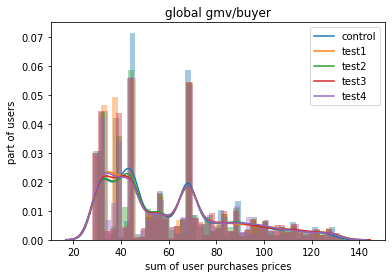

In [75]:
print("Графики суммы покупок пользователей (между 10% и 90% в порядке возрастания):")
df_visual = []
for i in range(0, 5):
    min_border = np.percentile(df_count_user_purchase[df_count_user_purchase['tag'] == tags[i]]['sum'], 10)
    max_border = np.percentile(df_count_user_purchase[df_count_user_purchase['tag'] == tags[i]]['sum'], 90)
    df_visual.append(df_count_user_purchase[(df_count_user_purchase['tag'] == tags[i]) & (df_count_user_purchase['sum'] > min_border) & (df_count_user_purchase['sum'] < max_border)])

sns.distplot(df_visual[0]['sum'], kde_kws={"label": "control"})
sns.distplot(df_visual[1]['sum'], kde_kws={"label": "test1"})
sns.distplot(df_visual[2]['sum'], kde_kws={"label": "test2"})
sns.distplot(df_visual[3]['sum'], kde_kws={"label": "test3"})
sns.distplot(df_visual[4]['sum'], kde_kws={"label": "test4"}).set(title='global gmv/buyer', xlabel='sum of user purchases prices', ylabel='part of users')

plt.savefig("GMVPerBuyer_" + 'all' + ".png")

# По разным типам товаров. Чтобы дальше не делать кучу раз копипасту, задефайним функции

In [76]:
alpha = 0.05

def compare(control, test1, test2, test3, test4):
    print("Все вместе")
    kruskal_result = stats.kruskal(control, test1, test2, test3, test4)
    print(kruskal_result)
    print()
    print("Между собой")
    if (kruskal_result.pvalue < alpha):
        print("pvalue < alpha = " + str(alpha) + ", значит, мы отклоняем нулевую гипотезу о том, что медианы выборок одинаковы")
        print("Для того, чтобы выяснить медианы каких именно выборок отличаются, запустим специальный post hoc Краскалла с отклоненной нулевой гипотезой тест Коновера-Имана с поправками Benjamini/Hochberg (non-negative).")
        print("Если значение p-value < alpha = " + str(alpha) + ", то медианы пары выборок отличаются значимо, иначе незначимо")
        pd.options.display.float_format = "{:,.3f}".format
        tmp = sp.posthoc_conover([control, test1, test2, test3, test4], p_adjust = 'fdr_bh')
        tmp.columns = ['control', 'test1', 'test2', 'test3', 'test4']
        tmp = tmp.rename(index={1: 'control', 2: 'test1', 3: 'test2', 4: 'test3', 5: 'test4'})
        print(tmp)
    else:
        print("Kruskal pvalue > alpha = " + str(alpha) + ", значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы")

def getUsers():
    print('users (всего пользователей):')
    print(df_users.groupby('tag')['user_uid'].count())
    print()
    print()

def getBuyers(mode):
    print('buyers (всего покупателей):')
    print(df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby(['tag', 'user_uid'])['price'].sum().groupby('tag').count())
    print()
    print()
    
def getCR(mode):
    print('CR user->buyer (конверсия из пользователя в покупателя):')
    print(df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby(['tag', 'user_uid'])['price'].sum().groupby('tag').count() / df_users.groupby('tag')['user_uid'].count())
    print()
    print("Проверяем значимость различий конверсий:")
    
    df_cr_mode = pd.DataFrame(columns=['user_uid', 'payed'])
    df_cr_mode['user_uid'] = df_purchases[df_purchases['consumption_mode'] == mode]['user_uid'].unique().tolist()
    df_cr_mode['payed'] = 1

    df_users_payed_mode = df_users.merge(df_cr_mode, how='left', on='user_uid')[['user_uid', 'tag', 'payed']].fillna(0)
    
    compare(df_users_payed_mode[df_users_payed_mode['tag'] == 'control']['payed'], \
            df_users_payed_mode[df_users_payed_mode['tag'] == 'test1']['payed'], \
            df_users_payed_mode[df_users_payed_mode['tag'] == 'test2']['payed'], \
            df_users_payed_mode[df_users_payed_mode['tag'] == 'test3']['payed'], \
            df_users_payed_mode[df_users_payed_mode['tag'] == 'test4']['payed'])
    print()
    print()

def getPurchases(mode):
    print('Purchases (всего покупок):')
    print(df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby('tag')['time'].count())
    print()
    print()

def getPurchasesPerBuyer(mode):
    df_count_user_purchase_mode = df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby(['tag', 'user_uid'])['price'].agg(['count', 'sum', 'mean']).reset_index()

    print('Purchases / buyer (среднее количество покупок на пользователя):')
    print(df_count_user_purchase_mode.groupby('tag')['count'].mean())
    print()
    print("Проверяем значимость различий количества покупок на покупателя:")
    
    compare(df_count_user_purchase_mode[df_count_user_purchase_mode['tag'] == 'control']['count'], \
            df_count_user_purchase_mode[df_count_user_purchase_mode['tag'] == 'test1']['count'], \
            df_count_user_purchase_mode[df_count_user_purchase_mode['tag'] == 'test2']['count'], \
            df_count_user_purchase_mode[df_count_user_purchase_mode['tag'] == 'test3']['count'], \
            df_count_user_purchase_mode[df_count_user_purchase_mode['tag'] == 'test4']['count'])
    print()
    print()
    
def getGMV(mode):
    print('total GMV (общая сумма покупок):')
    print(df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby('tag')['price'].sum())
    print()
    print()
    
def getGMVPerPurchase(mode):
    print('GMV / purchase (средняя сумма покупки):')
    print(df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby(['tag'])['price'].mean())
    print()
    print("Проверяем значимость различий стоимостей покупок:")
    
    compare(df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) & (df_purchases_tagged['tag'] == 'control')]['price'], \
            df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) & (df_purchases_tagged['tag'] == 'test1')]['price'], \
            df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) & (df_purchases_tagged['tag'] == 'test2')]['price'], \
            df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) & (df_purchases_tagged['tag'] == 'test3')]['price'], \
            df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) & (df_purchases_tagged['tag'] == 'test4')]['price'])
    print()
    print()

def getGMVPerBuyer(mode):
    print('GMV / buyer (средняя сумма покупок на пользователя):')
    print(df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby(['tag', 'user_uid'])['price'].agg(['sum']).groupby('tag')['sum'].mean())
    print()
    print("Проверяем значимость различий суммы покупок на пользователя:")
    df_sum_user_purchase_mode = df_purchases_tagged[df_purchases_tagged['consumption_mode'] == mode].groupby(['tag', 'user_uid'])['price'].agg(['sum']).reset_index()
    
    compare(df_sum_user_purchase_mode[df_sum_user_purchase_mode['tag'] == 'control']['sum'], \
            df_sum_user_purchase_mode[df_sum_user_purchase_mode['tag'] == 'test1']['sum'], \
            df_sum_user_purchase_mode[df_sum_user_purchase_mode['tag'] == 'test2']['sum'], \
            df_sum_user_purchase_mode[df_sum_user_purchase_mode['tag'] == 'test3']['sum'], \
            df_sum_user_purchase_mode[df_sum_user_purchase_mode['tag'] == 'test4']['sum'])

    print("Графики суммы покупок пользователей (между 10% и 90% в порядке возрастания):")
    df_visual = []
    for i in range(0, 5):
        min_border = np.percentile(df_sum_user_purchase_mode[df_sum_user_purchase_mode['tag'] == tags[i]]['sum'], 10)
        max_border = np.percentile(df_sum_user_purchase_mode[df_sum_user_purchase_mode['tag'] == tags[i]]['sum'], 90)
        df_visual.append(df_sum_user_purchase_mode[(df_sum_user_purchase_mode['tag'] == tags[i]) & (df_sum_user_purchase_mode['sum'] > min_border) & (df_sum_user_purchase_mode['sum'] < max_border)])
    
    sns.distplot(df_visual[0]['sum'], kde_kws={"label": "control"})
    sns.distplot(df_visual[1]['sum'], kde_kws={"label": "test1"})
    sns.distplot(df_visual[2]['sum'], kde_kws={"label": "test2"})
    sns.distplot(df_visual[3]['sum'], kde_kws={"label": "test3"})
    sns.distplot(df_visual[4]['sum'], kde_kws={"label": "test4"}).set(title='gmv/buyer for ' + mode, xlabel='sum of user purchases prices', ylabel='part of users')
    
    plt.savefig("GMVPerBuyer_" + mode + ".png")

def analyse(mode):
    print("Проверяем для типа покупок: ", mode)
    print("Уровень значимости alpha=0.05. Если pvalue < alpha, то различия значимы. Иначе незначимы.")
    getUsers()
    getBuyers(mode)
    getCR(mode)
    getPurchases(mode)
    getPurchasesPerBuyer(mode)
    getGMV(mode)
    getGMVPerPurchase(mode)
    getGMVPerBuyer(mode)

# По dto (покупкам навсегда)

Проверяем для типа покупок:  dto
Уровень значимости alpha=0.05. Если pvalue < alpha, то различия значимы. Иначе незначимы.
users (всего пользователей):
tag
control    138155
test1      139227
test2      138532
test3      138404
test4      138405
Name: user_uid, dtype: int64


buyers (всего покупателей):
tag
control    11554
test1      12923
test2      12607
test3      12804
test4      13142
Name: price, dtype: int64


CR user->buyer (конверсия из пользователя в покупателя):
tag
control   0.084
test1     0.093
test2     0.091
test3     0.093
test4     0.095
dtype: float64

Проверяем значимость различий конверсий:
Все вместе
KruskalResult(statistic=126.25965304505905, pvalue=2.455414198679844e-26)

Между собой
pvalue < alpha = 0.05, значит, мы отклоняем нулевую гипотезу о том, что медианы выборок одинаковы
Для того, чтобы выяснить медианы каких именно выборок отличаются, запустим специальный post hoc Краскалла с отклоненной нулевой гипотезой тест Коновера-Имана с поправками Benjamini/Hoc

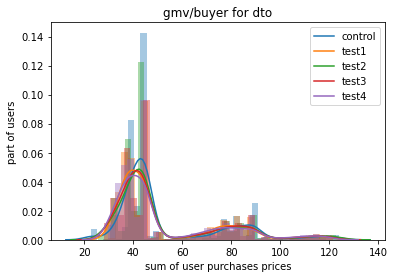

In [77]:
analyse('dto')

# По rent (контент в аренду)

Проверяем для типа покупок:  rent
Уровень значимости alpha=0.05. Если pvalue < alpha, то различия значимы. Иначе незначимы.
users (всего пользователей):
tag
control    138155
test1      139227
test2      138532
test3      138404
test4      138405
Name: user_uid, dtype: int64


buyers (всего покупателей):
tag
control    11417
test1      11789
test2      11859
test3      11719
test4      11621
Name: price, dtype: int64


CR user->buyer (конверсия из пользователя в покупателя):
tag
control   0.083
test1     0.085
test2     0.086
test3     0.085
test4     0.084
dtype: float64

Проверяем значимость различий конверсий:
Все вместе
KruskalResult(statistic=8.694599769358302, pvalue=0.06920320200884902)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы


Purchases (всего покупок):
tag
control    17487
test1      18332
test2      18119
test3      18081
test4      17814
Name: time, dtype: int64


Purchases / buyer (сре

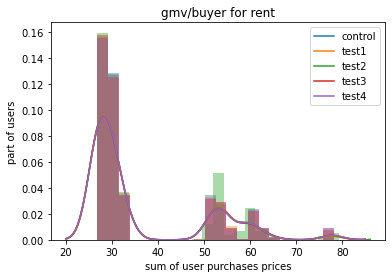

In [78]:
analyse('rent')

# По subscription (подписка)

Проверяем для типа покупок:  subscription
Уровень значимости alpha=0.05. Если pvalue < alpha, то различия значимы. Иначе незначимы.
users (всего пользователей):
tag
control    138155
test1      139227
test2      138532
test3      138404
test4      138405
Name: user_uid, dtype: int64


buyers (всего покупателей):
tag
control    14588
test1      15015
test2      14761
test3      14977
test4      14695
Name: price, dtype: int64


CR user->buyer (конверсия из пользователя в покупателя):
tag
control   0.106
test1     0.108
test2     0.107
test3     0.108
test4     0.106
dtype: float64

Проверяем значимость различий конверсий:
Все вместе
KruskalResult(statistic=7.213592991110122, pvalue=0.1250222217532129)

Между собой
Kruskal pvalue > alpha = 0.05, значит, нет оснований отклонять нулевую гипотезу о том, что медианы выборок одинаковы


Purchases (всего покупок):
tag
control    16592
test1      17157
test2      16904
test3      17058
test4      16767
Name: time, dtype: int64


Purchases / buy

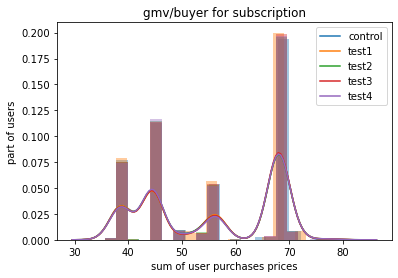

In [79]:
analyse('subscription')

# Соберем все вместе с помощью Excel

В файле result.xlsx собраны графики, числовые значения и решения о значимости.

Чтобы открыть скриншот таблицы, запустите следующий абзац:

In [80]:
from PIL import Image                                                                                
img = Image.open('result.png')
img.show()

# Промежуточный вывод

(вывод про равномерность распределения пользователей по группам -- выше)

===

В тестовых группах выявлены значимые изменения по следующим значениям метрик:

для всех типов товаров: рост конверсии на 3-4%, рост количества покупок пользователя на 2-2.5%, падение суммы заказа на 0.5-1%, рост трат пользователя на 1-2%.

для товаров типа dto (покупка навсегда): рост конверсии на 9-14%, не изменилось значимо количество покупок пользователя, рост трат пользователя на 1-2%, падение суммы заказа на 0.5-1%.

для товаров типа rent и subscription продуктовые метрики не изменились значимо.

===

Наибольшие положительные значимые изменения для дохода компании произошли в группе test2.

Сумма, которую пользователи оставляют в сервисе, суммарно не изменилась значимо для групп test1 и test4, но для товаров категории dto значимо уменьшилась.

===

#### Как так получается, что метрики дохода увеличиваются вместе с падением суммы заказа?

Мы знаем, что топ популярных товаров не изменился с началом теста. Учитывая равномерность распределения пользователей по группам и промежуточный вывод выше, возможно выдвинуть две гипотезы:

Гипотеза 1: стоимость товаров действительно понизилась, поэтому пользователи стали совершать больше покупок и суммарно больше оставлять в нашем продукте

Гипотеза 2: пользователи стали чаще покупать дешевые специфичные/не очень популярные товары

Гипотеза 2 вполне имеет право на существование, так как топ-20 покупок dto изменился сильно с началом теста. Но для ее проверки нужно иметь больше информации о товарах, такую как: время появление этого товара, зависимость популярности товара от сезона или события (на новый год популярны новогодние фильмы, а, если случился внезапно ураган, то про ураганы) и другую.

Гипотезу 1 можно проверить, что мы и сделаем сейчас:

In [81]:
df_purchases_elements.sort_values(by=['count'], ascending=False).head(50)

,element_uid,tag,consumption_mode,min,mean,max,var,count
19511,dd7f3f7b10fb9b502cbc5d1a9abc067b,test1,subscription,21.059,39.356,50.353,52.138,5749
19512,dd7f3f7b10fb9b502cbc5d1a9abc067b,test2,subscription,21.059,39.604,196.882,56.269,5692
19514,dd7f3f7b10fb9b502cbc5d1a9abc067b,test4,subscription,21.059,39.526,196.882,62.594,5665
19513,dd7f3f7b10fb9b502cbc5d1a9abc067b,test3,subscription,21.059,39.418,50.353,53.429,5603
19510,dd7f3f7b10fb9b502cbc5d1a9abc067b,control,subscription,21.059,39.363,50.353,53.641,5495
12183,8a6d58e6725f9122361450a13c9eb701,test3,subscription,44.471,66.023,68.000,41.384,5190
12181,8a6d58e6725f9122361450a13c9eb701,test1,subscription,44.471,66.531,402.765,54.721,5035
12184,8a6d58e6725f9122361450a13c9eb701,test4,subscription,44.471,66.298,138.059,37.079,4978
12182,8a6d58e6725f9122361450a13c9eb701,test2,subscription,44.471,66.377,138.059,35.173,4967
12180,8a6d58e6725f9122361450a13c9eb701,control,subscription,44.471,66.275,68.000,36.280,4937


In [82]:
def getMeanPrices(mode):
    print('Статистика средних, минимальных, максимальных и дисперсии цен на разные товары в зависимости от группы для типа товаров ' + mode + ':')
    count_elements = df_purchases[df_purchases['consumption_mode'] == mode].groupby('element_uid')['price'].agg(['count', 'sum', 'mean']).reset_index()
        
    for i in range(0, len(tags)):
        tmp = df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) \
                                  & (df_purchases_tagged['tag'] == tags[i])] \
                                    .groupby('element_uid')['price'].mean().reset_index()
        tmp.columns = ['element_uid', 'mean_' + mode + '_' + tags[i]]
        count_elements = count_elements.merge(tmp, on='element_uid', how='left')
        
    for i in range(0, len(tags)):
        tmp = df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) \
                                  & (df_purchases_tagged['tag'] == tags[i])] \
                                    .groupby('element_uid')['price'].min().reset_index()
        tmp.columns = ['element_uid', 'min_' + mode + '_' + tags[i]]
        count_elements = count_elements.merge(tmp, on='element_uid', how='left')
        
    for i in range(0, len(tags)):
        tmp = df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) \
                                  & (df_purchases_tagged['tag'] == tags[i])] \
                                    .groupby('element_uid')['price'].max().reset_index()
        tmp.columns = ['element_uid', 'max_' + mode + '_' + tags[i]]
        count_elements = count_elements.merge(tmp, on='element_uid', how='left')
        
    for i in range(0, len(tags)):
        tmp = df_purchases_tagged[(df_purchases_tagged['consumption_mode'] == mode) \
                                  & (df_purchases_tagged['tag'] == tags[i])] \
                                    .groupby('element_uid')['price'].var().reset_index()
        tmp.columns = ['element_uid', 'var_' + mode + '_' + tags[i]]
        count_elements = count_elements.merge(tmp, on='element_uid', how='left')

    count_elements = count_elements.dropna().sort_values(by='count', ascending=False).reset_index(drop=True)
    
    return count_elements

In [83]:
pd.set_option('display.max_columns', None)
mean_prices = getMeanPrices('dto')

mean_prices.head(20)

Статистика средних, минимальных, максимальных и дисперсии цен на разные товары в зависимости от группы для типа товаров dto:


,element_uid,count,sum,mean,mean_dto_control,mean_dto_test1,mean_dto_test2,mean_dto_test3,mean_dto_test4,min_dto_control,min_dto_test1,min_dto_test2,min_dto_test3,min_dto_test4,max_dto_control,max_dto_test1,max_dto_test2,max_dto_test3,max_dto_test4,var_dto_control,var_dto_test1,var_dto_test2,var_dto_test3,var_dto_test4
0,a579f32b5c116624cc661c9d3b96d5e5,15386,"635,083.353",41.277,42.014,40.580,41.939,41.239,40.721,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,38.052,32.559,29.898,31.570,31.917
1,8256d0fc7b25382aacfec0066e39cde3,5856,"234,716.471",40.081,41.067,39.481,40.437,40.099,39.411,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,27.692,29.045,28.244,27.794,30.729
2,433b78d303f6d499b72cb55a746f7c9c,5527,"207,940.000",37.623,39.688,38.512,36.732,36.931,36.815,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,32.655,29.460,39.372,38.797,39.542
3,ef81ae50ce292ed4ee547c775f29a35e,4532,"179,972.941",39.712,40.259,39.153,40.112,39.608,39.492,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,32.401,27.918,25.498,29.679,25.445
4,2ba66ac9785731da67b2b6155efaca5c,3469,"131,609.059",37.939,40.412,38.701,37.096,36.778,37.191,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,29.279,27.258,41.172,38.381,39.772
5,91149a8df75aa9c9f8bab2a2d777c856,2461,"95,585.471",38.840,39.032,38.254,39.583,38.933,38.596,21.059,21.059,21.059,21.059,21.059,59.824,59.824,59.824,59.824,59.824,56.098,46.623,48.901,47.615,44.983
6,194a4dd907083e2377e7b0f8b1d970e9,1847,"71,292.941",38.599,40.070,39.037,38.100,38.234,37.767,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,25.371,24.211,32.636,34.915,33.983
7,c182cf88cc73c97dc744c9a66cb247ae,1538,"55,912.353",36.354,35.953,35.719,36.156,37.706,36.282,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,114.697,75.691,108.141,84.054,73.194
8,d1e7961cec31b92522e159992a7afe71,1472,"55,878.000",37.961,38.099,38.000,38.116,37.985,37.570,21.059,21.059,21.059,21.059,21.059,41.529,41.529,41.529,41.529,41.529,20.746,20.754,23.781,21.584,23.360
9,3a7b384927d7fffa722a1deb5157a42e,1192,"48,125.059",40.373,41.115,39.410,41.048,40.767,39.628,21.059,21.059,21.059,21.059,21.059,44.471,44.471,44.471,44.471,44.471,20.118,31.984,22.405,16.816,23.198


Для популярных товаров минимумы и максимумы не меняются для одних и тех же element_uid, но средняя цена заметно ниже у тестовых групп в сравнении с контрольной

In [84]:
mean_prices = mean_prices[mean_prices['mean_dto_control'] != 0]
mean_prices['t3/c'] = mean_prices['mean_dto_test3'] / mean_prices['mean_dto_control']

In [85]:
np.mean(mean_prices['t3/c'].head(20)) - 1, np.mean(mean_prices['t3/c']) - 1

(-0.02225633291101836, -0.007509745419881586)

Проверим значимость отклонения средных цен для каждой парной выборки (средняя цена товара в контрольной и в тестовой группе).

Сначала проверим на нормальность

<AxesSubplot:xlabel='mean_dto_test4'>

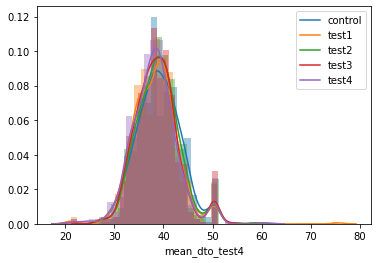

In [86]:
sns.distplot(mean_prices['mean_dto_control'], kde_kws={"label": "control"})
sns.distplot(mean_prices['mean_dto_test1'], kde_kws={"label": "test1"})
sns.distplot(mean_prices['mean_dto_test2'], kde_kws={"label": "test2"})
sns.distplot(mean_prices['mean_dto_test3'], kde_kws={"label": "test3"})
sns.distplot(mean_prices['mean_dto_test4'], kde_kws={"label": "test4"})

In [87]:
stats.normaltest(mean_prices['mean_dto_control'].head(20)), \
stats.normaltest(mean_prices['mean_dto_test1'].head(20)), \
stats.normaltest(mean_prices['mean_dto_test2'].head(20)), \
stats.normaltest(mean_prices['mean_dto_test3'].head(20)), \
stats.normaltest(mean_prices['mean_dto_test4'].head(20))

(NormaltestResult(statistic=0.8090295059109313, pvalue=0.6673005379221646),
 NormaltestResult(statistic=0.46471819266700654, pvalue=0.7926614303802909),
 NormaltestResult(statistic=1.416742018028789, pvalue=0.4924457340974847),
 NormaltestResult(statistic=3.3492757171386023, pvalue=0.18737602381793725),
 NormaltestResult(statistic=0.9003144438756712, pvalue=0.6375279103684253))

In [88]:
stats.normaltest(mean_prices['mean_dto_control']), \
stats.normaltest(mean_prices['mean_dto_test1']), \
stats.normaltest(mean_prices['mean_dto_test2']), \
stats.normaltest(mean_prices['mean_dto_test3']), \
stats.normaltest(mean_prices['mean_dto_test4'])

(NormaltestResult(statistic=16.818419151076665, pvalue=0.0002228058985683428),
 NormaltestResult(statistic=166.82672175633758, pvalue=5.9434368635592515e-37),
 NormaltestResult(statistic=42.576451200288, pvalue=5.683830162125577e-10),
 NormaltestResult(statistic=33.55015419629979, pvalue=5.1841383459709246e-08),
 NormaltestResult(statistic=44.74426514598659, pvalue=1.9226767522961136e-10))

pvalue < alpha = 0.05 для цен по всем типам товаров, что означает, что эти цены не из нормального распределения, поэтому будем использовать тест Вилкоксона для сравнения парных выборок по всем товарам. Для популярных же можно использовать тест Стьюдента

In [89]:
stats.ttest_rel(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test3'].head(20))

Ttest_relResult(statistic=2.1599569626360036, pvalue=0.0437642152666311)

In [90]:
stats.wilcoxon(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test3'].head(20), mode='exact')

WilcoxonResult(statistic=47.0, pvalue=0.029575347900390625)

In [91]:
stats.wilcoxon(mean_prices['mean_dto_control'], mean_prices['mean_dto_test3'])

WilcoxonResult(statistic=60996.0, pvalue=5.7397651258531166e-05)

pvalue < alpha = 0.05. Значит, отклонения значимы. Средняя цена товара снизилась для покупателей из тестовой группы 3. Для популярных товаров ниже на 2.2%, для всех на 31%.

При этом средний заказ, как мы помним, ниже на 2.4%, что соответствует этим числам, так как 20 популярных (из 4000 всего) составляют 50% от всех покупок dto (и по количеству, и по сумме)

Проверим, что для остальных тестовых групп значимость снижения средней цены

In [92]:
stats.ttest_rel(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test1'].head(20)), \
stats.wilcoxon(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test1'].head(20), mode='exact'), \
stats.wilcoxon(mean_prices['mean_dto_control'], mean_prices['mean_dto_test1'])

(Ttest_relResult(statistic=4.243747678462915, pvalue=0.00043923085888252866),
 WilcoxonResult(statistic=19.0, pvalue=0.0005855560302734375),
 WilcoxonResult(statistic=56147.5, pvalue=1.4097393649621185e-08))

In [93]:
stats.ttest_rel(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test2'].head(20)), \
stats.wilcoxon(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test2'].head(20), mode='exact'), \
stats.wilcoxon(mean_prices['mean_dto_control'], mean_prices['mean_dto_test2'])

(Ttest_relResult(statistic=1.4394832876925483, pvalue=0.16628651708194395),
 WilcoxonResult(statistic=81.0, pvalue=0.38837623596191406),
 WilcoxonResult(statistic=71093.0, pvalue=0.14361872922618124))

In [94]:
stats.ttest_rel(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test4'].head(20)), \
stats.wilcoxon(mean_prices['mean_dto_control'].head(20), mean_prices['mean_dto_test4'].head(20), mode='exact'), \
stats.wilcoxon(mean_prices['mean_dto_control'], mean_prices['mean_dto_test4'])

(Ttest_relResult(statistic=4.145086125347197, pvalue=0.0005501069390619317),
 WilcoxonResult(statistic=17.0, pvalue=0.0003948211669921875),
 WilcoxonResult(statistic=52034.0, pvalue=6.662066484959053e-12))

Для всех тестовых групп, кроме второй, верно, что средняя цена покупки как популярных товаров, так и всех, значимо изменилась (снизилась). Для второй тестовой группы -- не изменилась значимо (но при этом мы помним, что стоимость заказов значимо уменьшилась, впрочем, всего на 1.5%, когда другие тестовые группы на 2.3-3%).

# Окончательный вывод

## Задача: A/B тест

Был запущен сплит-тест (а/б-тест), направленный на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах

1. Какие вы можете сделать выводы? Какая группа показала лучшие результаты?
2. Можем ли мы как-то оценить из этих данных равномерность и валидность распределения юзеров по разным группам?
3. Если не ограничиваться теми данными, которые приведены в рамках этого задания, что ещё вы бы посчитали для оценки результатов групп?

Описание данных:

В таблице users_ приведена информация о том, какой юзер в какой момент времени попал в а/б тест:
tag - лэйбл группы (control - контрольная, остальные - тестовые)
ts - время, когда впервые был выдан tag. То есть, все события до наступления времени ts происходили с юзером до попадания в а/б тест
user_uid - внутренний id юзера (для матчинга со второй таблицей)
registration_time - время регистрации пользователя в сервисе
conv_ts - время совершения первой покупки пользователем в сервисе

В таблице purchases_ приведена информация о транзакциях пользователей из таблицы users_ до и во время а/б теста:
user_uid - внутренний id юзера (для матчинга со второй таблицей)
time - время совершения транзакции
consumption_mode - вид потребления контента (dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка)
element_uid - уникальный id единицы контента или подписки
price - цена (преобразованная)

Значения в полях price и всех полях, указывающих на время - преобразованы. Это значит, что значение в таблице не настоящее, но является линейным преобразованием реального значения, где ко всем значениям одного поля применено одно и то же преобразование - между ними сохранено отношение порядка. Ко всем полям, обозначающим время, применено одно и то же преобразование.

## Тест проведен корретно? Равномерно ли распределены пользователи по группам?

По всем основным показателям действий пользователей:
* Время попадания в тест
* Количество покупок до теста
* Сумма покупок до теста
* Средняя цена покупки до теста
* Время регистрации
* Время первой покупки

пользователи распределены равномерно по группам (но дополнительно следует убедиться в корректности "обрезки начала" таблицы purchases_, потому что она у нас неполная).

Это говорит о том, что с высокой вероятностью они действительно равномерно распределены по группам и результаты анализа будут валидны. Тест был поставлен удачно, такую же стратегию распределения по группам можно использовать и дальше.

Почему "с высокой вероятностью", а не точно? Пользователи выделяются и по другим показателям, такие как: пол, возраст, город, средний доход в городе, зарплата, интересы, последняя подписка на 12 месяцев, смотрят утром или ночью фильмы, карта банка и другие. Существует вероятность того, что "любители детских фильмов" никак не выделялись до теста, но попали в одну группу. А в тесте запустили в разном виде новое предложение с детскими фильмами. Конечно, эти любители сразу начнут покупать их. Мы увидим, что доход увеличился и совершим ошибку: отдадим предпочтение тому варианту, где больше любителей, а не тот, который более прибыльный. Аналогично, если бы, например, нововведение заключалось в скидке для обладателей карта Тинькофф Банк и в одну группу попадут больше их обладателей. Однако, так как изученные показатели действительно хорошие и по ним мы узнали, что распределение по группам равномерное, то вероятность такого очень мала. Но не 0.

В зависимости от поставленной гипотезы и проверяемой фичи дополнительно нужно проверять равномерность распределения по другим параметрам. Если мы, опять же, запускаем детские фильмы, то нужно проверять равномерность распределения по любителям детских фильмов (то есть хотя бы по возрасту или "в браке и >=30 лет (значит, есть ребенок)"). Если запускаем футбол, то нужно проверять, что везде мужчин поровну. Если балет - то женщин. И так далее.

Поняв, что распределение пользователей по группам равномерное, мы теперь можем утверждать, что полученный в процессе анализа результат ценен. Перейдем к нему.

## Результат

Основные метрики, значимость изменений и графики в таблице "NumbersAndGraphics.xlsx" и на ее скриншоте "result.png" представленном ниже:

<img src="files/result.png">

В тестовых группах выявлены значимые изменения по следующим значениям метрик:

для всех типов товаров: рост конверсии на 3.0-4.0%, рост количества покупок пользователя на 2.1-2.6%, падение суммы заказа на 0.6-1.2%, рост трат пользователя на 1.2-1.9%.

для товаров типа dto (покупка навсегда): рост конверсии на 8.8-13.5%, не изменилось значимо количество покупок пользователя, рост трат пользователя на 0.4% для test2 и падение на 1.1-2.1% для остальных, падение суммы заказа на 1.5-3.1%.

для товаров типа rent и subscription метрики не изменились значимо.

===

**Наибольшие положительные значимые изменения для дохода компании произошли в группе test2.** 

Траты пользователя по всем категориям товаров не изменились значимо для групп test1 и test4, но для товаров категории dto значимо уменьшилась.

Интересно, что траты пользователя по всем категориям товаров увеличились значимо для test3, но значимо упали для категории dto и не изменились значимо для rent и subscription. Это объясняется тем, что dto+rent+subscription/dto/rent/subscription не независимы (действительно, если пользователь купит подписку, то будет покупать меньше фильмов и арендовать их; если арендует фильм, то вряд ли купит его; если купил, то не арендует уже)

## Что дальше?

Мы поняли, что за счет нововведения, снижающего конечную среднюю цену товаров, пользователи начинают значимо чаще совершать заказы и тратить в итоге больше денег. Причем важен сам факт скидки и из-за этого факта происходит "скачок" метрик. С дальнейшим снижением цены количество покупок на пользователя не увеличивается, но суммарные траты пользователя быстро уменьшаются. Теперь главные вопросы:
* Почему? Раньше ведь цена тоже варьировалась
* Как мы можем еще помочь пользователям принимать решение о покупке?
* Как нам дальше развивать продукт и увеличивать прибыль?

Чтобы ответить на них нужно понять (под пунктами примеры ситуаций):
1. Что именно отличается в тестовом и контрольном дизайнах и как это может логически влиять на совершение/не совершение заказа + сравнить с конкурентами с похожими товарами
    * Пользователи теперь показывается, что "это скидка", а не безмолвно меняется цена
    * В тестовом дизайне делается небольшая скидка и на весь экран пишут "успей, пока цена снижена!". Из-за давления пользователи начинают совершать покупки
    * Эти товары были в списке "понравившихся" и мы просто сообщили пользователю, что на них вот наконец случилась скидка и он купил
    * Мы сообщили, что с заказа оплаченного с помощью карты Тинькофф Банка дается кешбек 1-3%, и это стало решающим для некоторых пользователей
    * Рекомендации со скидками начали работать гораздо лучше и пользователи начали чаще пользоваться ими
    * Возможно, что скидки временами всегда были, но появились "отложенные" и кнопка "уведомить о снижении цены" и пользователи пользуются ими, теперь им удобно следить за ценами, они чаще замечают снижение цены и действительно покупают
    * В тестовом дизайне сразу в лицо пользователя показывают какие фильмы "вот только что вышли", а на новые фильмы небольшая скидка
    * Появилась реферальная программа, за которую дают скидки на фильмы. Пользователь приглашает друга и сразу пользуется этой скидкой
    * Появилась накопительная программа бонусов и скидок за покупки, с которой пользователям действительно интереснее стало совершать покупки
1. Мы не знаем какое именно нововведение было, поэтому интересно, что отличает тестовые группы друг от друга и почему test2 лучше остальных, а конверсия test4 по dto выше, чем у других групп
    * Скидка демонстрируется более заметным образом
    * Рекомендации сработали лучше: больше фильмов на тему, которая близка пользователю; больше высокорейтинговых фильмов, которые он не видел еще; больше новинок в карусели рекомендаций; рекомендации "похожих" точнее и т.п.
    * Кнопка "купить" крупнее и заметнее
    * Просто размер скидки больше и пользователи охотнее покупают
    * Важен просто факт скидки, а у test2 наименьшее снижение цены, соответственно, скачкообразное увеличение цены компенсировала с лихом уменьшение средней цены товара

## Несколько задач для аналитиков

1. Посмотреть на поведение пользователей из группы control и test2 (и других тестовых). Что делают пользователи перед покупкой товара? Сравнивают его с другими? Просматривают рекомендации? Нажимают кнопку "поделиться"? Проверяют "отложенные"? Проходят по ссылке из почтовой рассылки?
1. Изучить данные, связанные с конкретным нововведением, и понять, что еще отличает контрольную от тестовых групп, тестовые группы друг от друга и почему test2 лучшая. Если это карусель с рекомендациями фильмов, то можно посмотреть на долю фильмов про спорт, долю новинок, рейтинг фильмов, рейтинг новинок, сколько из них фильмов, на которые пользователь уже тыкал и т.п. Если это просто скидка, то какой размер скидки, как зависит скидка от фильма (на новые или на старые, популярные, новинки, про спорт, из "отложенных", "просмотренные несколько раз").
1. **Не про это нововведение:** посмотреть от чего зависит популярность покупок фильмов (до и после начала теста были популярны разные фильмы), связано ли это с тем, что популярные фильмы "актуальны ситуации в мире", соответствуют времени года, событию (новый год, день влюбленных или SpaceX отправил человека на МКС и стали популярны фильмы про космос), просто новые или новые с высоким рейтингом.
1. Проверить равномерность распределения пользователям по группам в зависимости от других параметров, например, сильноспецифичных для этого нововведения. Если нововведение -- скидка за оплату по Тинькофф, то проверить, что везде одинаковая доля тех, кто пользовался картой Тинькофф. Или по параметрам наподобие вида последней оформленной подписки, сколько времени еще будет действовать и т.п.
1. Сравнить прибыль по группам, а не доходы с покупок.
1. Сравнить доходы по пользователям в единицу времени (сколько тратит в месяц), а не за все время тестирования.
1. Провести такую же аналитику по каждой из 4 популярных подписок. (но, скорее всего, мы не увидим значимых различий)
1. Убедиться в корректности "обрезки начала" таблицы purchases_, потому что она у нас неполная и подсчет метрик для определения равномерности распределения пользователей по группам и вывод о том, что оно равномерно, могли быть некорректны.

## Вердикт

Split тестирование проведено качественно и однозначно успешно: тестовые группы и, в особенности, вторая, показали значимый рост метрик связанных с доходом (рост конверсии на 3.0-4.0%, рост количества покупок пользователя на 2.1-2.6% и рост трат пользователя на 1.2-1.9%). При рассмотрении отдельных типов товаров значимые изменения обнаружились лишь по продуктам типа dto, покупаемые пользователями навсегда (составляют ~37% от общего дохода и количества заказов), где произошел рост конверсии на 8.8-13.5%. Вместе с тем средняя стоимость заказа и товаров снизилась (на 0.6-1.2%)

Со скидкой произошел скачок конверсии и количества покупок на пользователя. При незначительном снижении скачок компенсирует это падение и в итоге получается доход значительно выше, чем в контрольной группе (в группах test2 и test3). В группе test2, в которой цена снизилась меньше всего, траты пользователя и по всем типам товаров, и по dto максимальны, в то время как в других группах конверсия оба раза выше, но траты пользователя по dto упали. Что дает основания сделать вывод, что test2 -- лучшая группа с точки зрения дохода компании (но не по конверсии). Из этого можно сделать вывод, что, скорее всего, просто факт скидки увеличивает конверсию и ее можно сделать достаточно малой, чтобы общий доход увеличился.

При принятии решения о дальнейшей раскатке нововведения важно помнить, что доход != прибыль. Хоть доход и конверсия и выше в тестовых группах, прибыль могла снизиться, что делает нецелесообразным дальнейшую раскатку нововведения, если нам сейчас важна прибыль. Также, возможно, целесообразно оставить нововведения только для товаров dto (если оно было для всех товаров), если это экономит что-либо: железо (если меньше данных хранить и считать нужно или скорость выдачи понижаем), работу операторов чатов, работу фотографов, редакторов). А для товаров dto усилить сильные стороны решения test2. Дополнительная аналитика и понимание нововведения поможет лучше понять, что побудило пользователей совершать больше заказов, какие новые идеи могут помочь пользователям и, соответственно, увеличить нашу прибыль. 